# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import os

# Loading data and select features

## Import Data

In [2]:
# Set data path for Kaggle
if os.environ.get('KAGGLE_KERNEL_RUN_TYPE', 'Localhost') == 'Interactive':
    loan_data_preprocessed_backup = pd.read_csv('/kaggle/input/creditrisk-train-test/loan_data_2007_2014_preprocessed.csv', index_col=0)
else:
    loan_data_preprocessed_backup = pd.read_csv('../data/loan_data_2007_2014_preprocessed.csv', index_col=0)

/tmp/ipykernel_62996/2784625602.py:5: DtypeWarning: Columns (21,49) have mixed types. Specify dtype option on import or set low_memory=False.
  loan_data_preprocessed_backup = pd.read_csv('../data/loan_data_2007_2014_preprocessed.csv', index_col=0)


## Explore Data

In [3]:
loan_data_preprocessed = loan_data_preprocessed_backup

In [4]:
loan_data_preprocessed.head()

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,addr_state:UT,addr_state:VA,addr_state:VT,addr_state:WA,addr_state:WI,addr_state:WV,addr_state:WY,initial_list_status:f,initial_list_status:w,good_bad
0,0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,...,0,0,0,0,0,0,0,1,0,1
1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,...,0,0,0,0,0,0,0,1,0,0
2,2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,...,0,0,0,0,0,0,0,1,0,1
3,3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,...,0,0,0,0,0,0,0,1,0,1
4,4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,...,0,0,0,0,0,0,0,1,0,1


Modeling for the account status `Default` not recommended since at default the client still have time to pay and recover.  
Then select account status  `charge of`. 

In [5]:
loan_data_preprocessed["loan_status"].unique()

array(['Fully Paid', 'Charged Off', 'Current', 'Default',
       'Late (31-120 days)', 'In Grace Period', 'Late (16-30 days)',
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off'],
      dtype=object)

In [6]:
loan_data_defaults = loan_data_preprocessed[loan_data_preprocessed["loan_status"].isin(["Charged Off", 
                                                                                        "Does not meet the credit policy. Status:Charged Off'"])]

In [7]:
loan_data_defaults.shape

(42475, 208)

In [8]:
loan_data_preprocessed.isna().sum()[loan_data_defaults.isna().sum() > 1]

emp_title                       27588
emp_length                      21008
desc                           340304
title                              21
mths_since_last_delinq         250351
mths_since_last_record         403647
revol_util                        340
last_pymnt_d                      376
next_pymnt_d                   227214
last_credit_pull_d                 42
collections_12_mths_ex_med        145
mths_since_last_major_derog    367311
annual_inc_joint               466285
dti_joint                      466285
verification_status_joint      466285
tot_coll_amt                    70276
tot_cur_bal                     70276
open_acc_6m                    466285
open_il_6m                     466285
open_il_12m                    466285
open_il_24m                    466285
mths_since_rcnt_il             466285
total_bal_il                   466285
il_util                        466285
open_rv_12m                    466285
open_rv_24m                    466285
max_bal_bc  

The LGD , EAD model need not to be comprehensible , then no need to do fine classing & Woe for categorical variable.  
And continuous variable use as it is.  

In [9]:
loan_data_defaults = loan_data_defaults.fillna({"mths_since_last_delinq":0, "mths_since_last_record":0})

## Dependence variable

In [10]:
loan_data_defaults["recovery_rate"] = loan_data_defaults["recoveries"] / loan_data_defaults["funded_amnt"]

In [11]:
loan_data_defaults["recovery_rate"].describe()

count    42475.000000
mean         0.060802
std          0.088033
min          0.000000
25%          0.000000
50%          0.030302
75%          0.114715
max          1.220774
Name: recovery_rate, dtype: float64

In [12]:
loan_data_defaults["recovery_rate"] = np.select([loan_data_defaults["recovery_rate"] > 1,
                                                 loan_data_defaults["recovery_rate"] < 0],
                                                [1, 
                                                 0],
                                                default=loan_data_defaults["recovery_rate"])                                                

In [13]:
loan_data_defaults["recovery_rate"].describe()

count    42475.000000
mean         0.060763
std          0.087586
min          0.000000
25%          0.000000
50%          0.030302
75%          0.114715
max          1.000000
Name: recovery_rate, dtype: float64

Credit conversion factor (CCF) = Exposure at default = amount unpaided / total funded amt

In [14]:
loan_data_defaults["CCF"] = (loan_data_defaults["funded_amnt"] - loan_data_defaults["total_rec_prncp"])/loan_data_defaults["funded_amnt"]

In [15]:
loan_data_defaults["CCF"].describe()

count    42475.000000
mean         0.737033
std          0.199849
min          0.000438
25%          0.634095
50%          0.790682
75%          0.888871
max          1.000000
Name: CCF, dtype: float64

## Explore Dependenct Variables

In [16]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style()

(array([2.065e+04, 1.654e+03, 3.767e+03, 1.386e+03, 2.129e+03, 3.336e+03,
        4.757e+03, 1.710e+03, 1.173e+03, 3.990e+02, 3.360e+02, 2.740e+02,
        1.100e+02, 9.100e+01, 8.100e+01, 7.200e+01, 5.400e+01, 6.900e+01,
        5.400e+01, 2.700e+01, 4.400e+01, 2.700e+01, 1.600e+01, 1.500e+01,
        1.900e+01, 2.200e+01, 1.700e+01, 7.000e+00, 9.000e+00, 6.000e+00,
        8.000e+00, 6.000e+00, 7.000e+00, 6.000e+00, 5.000e+00, 9.000e+00,
        4.000e+00, 1.000e+01, 8.000e+00, 9.000e+00, 4.000e+00, 6.000e+00,
        6.000e+00, 3.000e+00, 8.000e+00, 7.000e+00, 1.400e+01, 7.000e+00,
        8.000e+00, 2.900e+01]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ]),
 <BarContainer object of 50 

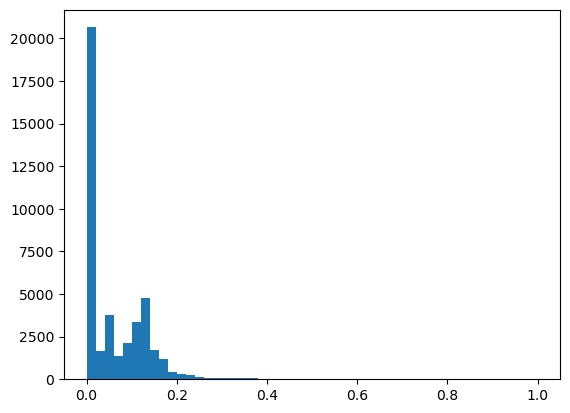

In [17]:
plt.hist(loan_data_defaults["recovery_rate"], bins=50)

(array([  19.,   58.,   29.,   92.,   67.,   80.,  144.,   75.,  121.,
         168.,  145.,  202.,  187.,  219.,  230.,  267.,  296.,  318.,
         328.,  362.,  400.,  414.,  497.,  493.,  567.,  573.,  605.,
         716.,  746.,  793.,  819.,  920.,  938., 1121., 1195., 1396.,
        1404., 1559., 1704., 1824., 1964., 2130., 2106., 2345., 2420.,
        2654., 2328., 2081., 1496.,  860.]),
 array([4.3800000e-04, 2.0429240e-02, 4.0420480e-02, 6.0411720e-02,
        8.0402960e-02, 1.0039420e-01, 1.2038544e-01, 1.4037668e-01,
        1.6036792e-01, 1.8035916e-01, 2.0035040e-01, 2.2034164e-01,
        2.4033288e-01, 2.6032412e-01, 2.8031536e-01, 3.0030660e-01,
        3.2029784e-01, 3.4028908e-01, 3.6028032e-01, 3.8027156e-01,
        4.0026280e-01, 4.2025404e-01, 4.4024528e-01, 4.6023652e-01,
        4.8022776e-01, 5.0021900e-01, 5.2021024e-01, 5.4020148e-01,
        5.6019272e-01, 5.8018396e-01, 6.0017520e-01, 6.2016644e-01,
        6.4015768e-01, 6.6014892e-01, 6.8014016e-01, 7.0

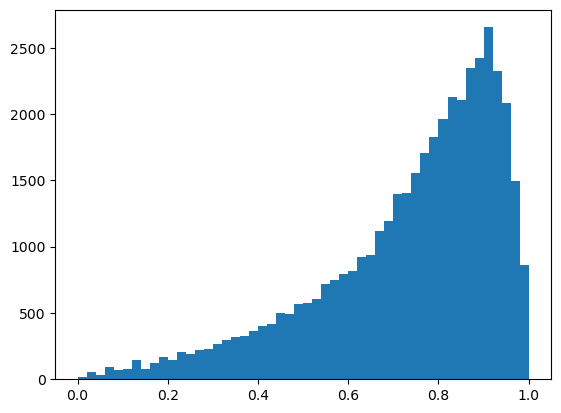

In [18]:
plt.hist(loan_data_defaults["CCF"], bins=50)

In [19]:
loan_data_defaults["recovery_rate_0_1"] = np.where(loan_data_defaults["recovery_rate"] == 0, 0, 1)
loan_data_defaults["recovery_rate_0_1"]

1         1
8         1
9         1
12        1
14        1
         ..
466254    0
466256    0
466276    1
466277    0
466281    0
Name: recovery_rate_0_1, Length: 42475, dtype: int64

# LGD model

## Splitting data

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
lgd_inputs_stage_1_train, lgd_inputs_stage_1_test, lgd_targets_stage_1_train, lgd_targets_stage_1_test = train_test_split(loan_data_defaults.drop(["good_bad", "recovery_rate", "recovery_rate_0_1", "CCF"], axis="columns"), loan_data_defaults["recovery_rate_0_1"], test_size=0.2, random_state=42)

## Preparing the inputs

In [22]:
features_all = ['grade:A',
'grade:B',
'grade:C',
'grade:D',
'grade:E',
'grade:F',
'grade:G',
'home_ownership:MORTGAGE',
'home_ownership:NONE',
'home_ownership:OTHER',
'home_ownership:OWN',
'home_ownership:RENT',
'verification_status:Not Verified',
'verification_status:Source Verified',
'verification_status:Verified',
'purpose:car',
'purpose:credit_card',
'purpose:debt_consolidation',
'purpose:educational',
'purpose:home_improvement',
'purpose:house',
'purpose:major_purchase',
'purpose:medical',
'purpose:moving',
'purpose:other',
'purpose:renewable_energy',
'purpose:small_business',
'purpose:vacation',
'purpose:wedding',
'initial_list_status:f',
'initial_list_status:w',
'term_int',
'emp_length_int',
'mths_since_issue_d',
'mths_since_earliest_cr_line',
'funded_amnt',
'int_rate',
'installment',
'annual_inc',
'dti',
'delinq_2yrs',
'inq_last_6mths',
'mths_since_last_delinq',
'mths_since_last_record',
'open_acc',
'pub_rec',
'total_acc',
'acc_now_delinq',
'total_rev_hi_lim']
# List of all independent variables for the models.

In [23]:
features_reference_cat = ['grade:G',
'home_ownership:RENT',
'verification_status:Verified',
'purpose:credit_card',
'initial_list_status:f']
# List of the dummy variable reference categories. 

In [24]:
lgd_inputs_stage_1_train = lgd_inputs_stage_1_train[features_all]
lgd_inputs_stage_1_train = lgd_inputs_stage_1_train.drop(features_reference_cat, axis="columns")

## Estimating The model

In [25]:
from sklearn import linear_model
import scipy.stats as stat

class LogisticRegression_with_p_values:
    
    def __init__(self,*args,**kwargs):
        self.model = linear_model.LogisticRegression(*args,**kwargs)

    def fit(self,X,y):
        self.model.fit(X,y)
        denom = (2.0 * (1.0 + np.cosh(self.model.decision_function(X))))
        denom = np.tile(denom,(X.shape[1],1)).T
        F_ij = np.dot((X / denom).T,X)
        Cramer_Rao = np.linalg.inv(np.array(F_ij, dtype='float64'))
        sigma_estimates = np.sqrt(np.diagonal(Cramer_Rao))
        z_scores = self.model.coef_[0] / sigma_estimates
        p_values = [stat.norm.sf(abs(x)) * 2 for x in z_scores]
        self.coef_ = self.model.coef_
        self.intercept_ = self.model.intercept_
        self.p_values = p_values

In [26]:
reg_lgd_st_1 = LogisticRegression_with_p_values()
reg_lgd_st_1.fit(lgd_inputs_stage_1_train, lgd_targets_stage_1_train)

/home/danny/miniconda3/envs/dask/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [27]:
reg_lgd_st_1.model.feature_names_in_

array(['grade:A', 'grade:B', 'grade:C', 'grade:D', 'grade:E', 'grade:F',
       'home_ownership:MORTGAGE', 'home_ownership:NONE',
       'home_ownership:OTHER', 'home_ownership:OWN',
       'verification_status:Not Verified',
       'verification_status:Source Verified', 'purpose:car',
       'purpose:debt_consolidation', 'purpose:educational',
       'purpose:home_improvement', 'purpose:house',
       'purpose:major_purchase', 'purpose:medical', 'purpose:moving',
       'purpose:other', 'purpose:renewable_energy',
       'purpose:small_business', 'purpose:vacation', 'purpose:wedding',
       'initial_list_status:w', 'term_int', 'emp_length_int',
       'mths_since_issue_d', 'mths_since_earliest_cr_line', 'funded_amnt',
       'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'total_acc',
       'acc_now_delinq', 'total_rev_hi_lim'], dtype=object)

In [28]:
feature_name = lgd_inputs_stage_1_train.columns

In [29]:
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
summary_table['Coefficients'] = reg_lgd_st_1.coef_.transpose()
summary_table.index = summary_table.index + 1
summary_table.loc[0] = ['Intercept', reg_lgd_st_1.intercept_[0]]
summary_table = summary_table.sort_index()

p_values = reg_lgd_st_1.p_values
p_values = np.append(np.nan, np.array(p_values))
summary_table['p_values'] = p_values
summary_table

,Feature name,Coefficients,p_values
0,Intercept,-2.660598e-04,NaN
1,grade:A,-3.646445e-05,9.996720e-01
2,grade:B,-1.885507e-04,9.978983e-01
3,grade:C,-2.299985e-04,9.973202e-01
4,grade:D,-5.663094e-06,9.999361e-01
5,grade:E,4.320904e-05,9.995562e-01
6,grade:F,1.343052e-04,9.988009e-01
7,home_ownership:MORTGAGE,-1.327272e-04,9.958853e-01
8,home_ownership:NONE,1.944267e-06,9.999980e-01
9,home_ownership:OTHER,1.151307e-06,9.999982e-01


## Test the model

In [30]:
lgd_inputs_stage_1_test = lgd_inputs_stage_1_test[features_all]
lgd_inputs_stage_1_test = lgd_inputs_stage_1_test.drop(features_reference_cat, axis="columns")

In [31]:
lgd_inputs_stage_1_test.columns

Index(['grade:A', 'grade:B', 'grade:C', 'grade:D', 'grade:E', 'grade:F',
       'home_ownership:MORTGAGE', 'home_ownership:NONE',
       'home_ownership:OTHER', 'home_ownership:OWN',
       'verification_status:Not Verified',
       'verification_status:Source Verified', 'purpose:car',
       'purpose:debt_consolidation', 'purpose:educational',
       'purpose:home_improvement', 'purpose:house', 'purpose:major_purchase',
       'purpose:medical', 'purpose:moving', 'purpose:other',
       'purpose:renewable_energy', 'purpose:small_business',
       'purpose:vacation', 'purpose:wedding', 'initial_list_status:w',
       'term_int', 'emp_length_int', 'mths_since_issue_d',
       'mths_since_earliest_cr_line', 'funded_amnt', 'int_rate', 'installment',
       'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths',
       'mths_since_last_delinq', 'mths_since_last_record', 'open_acc',
       'pub_rec', 'total_acc', 'acc_now_delinq', 'total_rev_hi_lim'],
      dtype='object')

In [32]:
y_hat_test_lgd_stage_1 = reg_lgd_st_1.model.predict(lgd_inputs_stage_1_test)

In [33]:
y_hat_test_lgd_stage_1

array([1, 0, 1, ..., 1, 1, 0])

In [38]:
y_hat_test_proba_lgd_stage_1 = reg_lgd_st_1.model.predict_proba(lgd_inputs_stage_1_test)

In [75]:
y_hat_test_proba_lgd_stage_1[:, [1]].shape

(8495, 1)

In [76]:
y_hat_test_proba_lgd_stage_1[:, 1].shape

(8495,)

In [77]:
y_hat_test_proba_lgd_stage_1 = y_hat_test_proba_lgd_stage_1[:][: , 1]
# equivalant command convert MxN - > 1D array
# y_hat_test_proba_lgd_stage_1[:, 1]

In [78]:
y_hat_test_proba_lgd_stage_1

array([0.61951654, 0.30942016, 0.68572839, ..., 0.51010723, 0.54587668,
       0.48388439])

In [79]:
y_hat_test_proba_lgd_stage_1.shape

(8495,)

In [80]:
lgd_targets_stage_1_test_temp = lgd_targets_stage_1_test

In [81]:
lgd_targets_stage_1_test_temp.reset_index(drop = True, inplace=True)

In [82]:
df_actual_predicted_probs = pd.concat([lgd_targets_stage_1_test_temp, pd.DataFrame(y_hat_test_proba_lgd_stage_1)], axis="columns")

In [83]:
df_actual_predicted_probs.columns = ["lgd_targets_stage_1_test", "y_hat_test_proba_lgd_stage_1"]

In [84]:
df_actual_predicted_probs.index = lgd_inputs_stage_1_test.index

In [85]:
df_actual_predicted_probs

,lgd_targets_stage_1_test,y_hat_test_proba_lgd_stage_1
88068,1,0.619517
340018,0,0.309420
3816,0,0.685728
29236,0,0.767133
109278,1,0.619273
...,...,...
75210,0,0.544232
154437,1,0.498729
375491,0,0.510107
221720,1,0.545877


## Estimating the Accuracy of the Model

In [86]:
tr = 0.5
df_actual_predicted_probs["y_hat_test_lgd_stage_1"] = np.where(df_actual_predicted_probs["y_hat_test_proba_lgd_stage_1"] > tr, 1, 0)

In [88]:
pd.crosstab(df_actual_predicted_probs["lgd_targets_stage_1_test"], df_actual_predicted_probs["y_hat_test_lgd_stage_1"], rownames=["Actual"], colnames=["Predicted"])

Predicted,0,1
Actual,,
0,1299,2399
1,876,3921


In [89]:
from sklearn.metrics import roc_auc_score, roc_curve

In [93]:
fpr, tpr, thresholds = roc_curve(df_actual_predicted_probs["lgd_targets_stage_1_test"], df_actual_predicted_probs["y_hat_test_lgd_stage_1"])

In [94]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_theme()

Text(0.5, 1.0, 'ROC Curve')

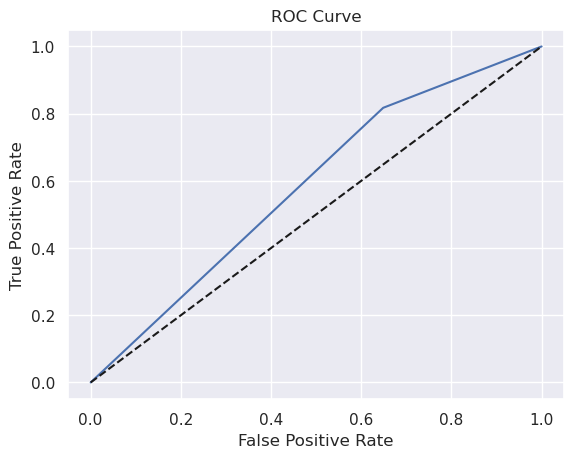

In [95]:
plt.plot(fpr, tpr)
plt.plot(fpr, fpr, linestyle="--", color="k")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")

In [96]:
AUROC = roc_auc_score(df_actual_predicted_probs["lgd_targets_stage_1_test"], df_actual_predicted_probs["y_hat_test_proba_lgd_stage_1"])
AUROC

0.6578960304309537

## Save the model

In [97]:
import pickle
pickle.dump(reg_lgd_st_1, open("../data/lgd_model_stage_1.sav", "wb"))

## LGD : stage 2 - Liner Regression

In [98]:
lgd_stage_2_data = loan_data_defaults[loan_data_defaults["recovery_rate_0_1"] == 1]

In [104]:
lgd_inputs_stage_2_train, lgd_inputs_stage_2_test, lgd_targets_stage_2_train, lgd_targets_stage_2_test = train_test_split(lgd_stage_2_data.drop(["good_bad", "recovery_rate", "recovery_rate_0_1", "CCF"], axis="columns"), lgd_stage_2_data["recovery_rate"], test_size=0.2, random_state=42)

In [110]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [113]:
# Since the p-values are obtained through certain statistics, we need the 'stat' module from scipy.stats
import scipy.stats as stat

# Since we are using an object oriented language such as Python, we can simply define our own 
# LinearRegression class (the same one from sklearn)
# By typing the code below we will ovewrite a part of the class with one that includes p-values
# Here's the full source code of the ORIGINAL class: https://github.com/scikit-learn/scikit-learn/blob/7b136e9/sklearn/linear_model/base.py#L362


class LinearRegression(linear_model.LinearRegression):
    """
    LinearRegression class after sklearn's, but calculate t-statistics
    and p-values for model coefficients (betas).
    Additional attributes available after .fit()
    are `t` and `p` which are of the shape (y.shape[1], X.shape[1])
    which is (n_features, n_coefs)
    This class sets the intercept to 0 by default, since usually we include it
    in X.
    """
    
    # nothing changes in __init__
    def __init__(self, fit_intercept=True, normalize=False, copy_X=True,
                 n_jobs=1):
        super().__init__(fit_intercept=fit_intercept, copy_X=copy_X, n_jobs=n_jobs)
        self.fit_intercept = fit_intercept
        self.normalize = normalize
        self.copy_X = copy_X
        self.n_jobs = n_jobs

    
    def fit(self, X, y, n_jobs=1):
        self = super(LinearRegression, self).fit(X, y, n_jobs)
        
        # Calculate SSE (sum of squared errors)
        # and SE (standard error)
        sse = np.sum((self.predict(X) - y) ** 2, axis=0) / float(X.shape[0] - X.shape[1])
        se = np.array([np.sqrt(np.diagonal(sse * np.linalg.inv(np.dot(X.T, X))))])

        # compute the t-statistic for each feature
        self.t = self.coef_ / se
        # find the p-value for each feature
        self.p = np.squeeze(2 * (1 - stat.t.cdf(np.abs(self.t), y.shape[0] - X.shape[1])))
        return self

In [107]:
lgd_inputs_stage_2_train = lgd_inputs_stage_2_train[features_all]

In [108]:
lgd_inputs_stage_2_train = lgd_inputs_stage_2_train.drop(features_reference_cat, axis = 1)

In [114]:
reg_lgd_st_2 = LinearRegression()
reg_lgd_st_2.fit(lgd_inputs_stage_2_train, lgd_targets_stage_2_train)

LinearRegression()

In [115]:
feature_name = lgd_inputs_stage_2_train.columns.values


In [117]:
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
summary_table['Coefficients'] = np.transpose(reg_lgd_st_2.coef_)
summary_table.index = summary_table.index + 1
summary_table.loc[0] = ['Intercept', reg_lgd_st_2.intercept_]
summary_table = summary_table.sort_index()
p_values = reg_lgd_st_2.p
p_values = np.append(np.nan,np.array(p_values))
summary_table['p_values'] = p_values.round(3)
summary_table

,Feature name,Coefficients,p_values
0,Intercept,2.264341e-01,NaN
1,grade:A,-4.815164e-02,0.000
2,grade:B,-3.688998e-02,0.000
3,grade:C,-2.532823e-02,0.000
4,grade:D,-1.739225e-02,0.000
5,grade:E,-6.432096e-03,0.126
6,grade:F,-1.451865e-03,0.761
7,home_ownership:MORTGAGE,3.681100e-03,0.011
8,home_ownership:NONE,2.727074e-01,0.000
9,home_ownership:OTHER,-4.963639e-03,0.831


## LGD : stage 2 - Liner Regression Evaluation

In [118]:
lgd_inputs_stage_2_test = lgd_inputs_stage_2_test[features_all]
# Here we keep only the variables we need for the model.

In [119]:
lgd_inputs_stage_2_test = lgd_inputs_stage_2_test.drop(features_reference_cat, axis = 1)
# Here we remove the dummy variable reference categories.

In [120]:
lgd_inputs_stage_2_test.columns.values
# Calculates the predicted values for the dependent variable (targets)
# based on the values of the independent variables (inputs) supplied as an argument.

array(['grade:A', 'grade:B', 'grade:C', 'grade:D', 'grade:E', 'grade:F',
       'home_ownership:MORTGAGE', 'home_ownership:NONE',
       'home_ownership:OTHER', 'home_ownership:OWN',
       'verification_status:Not Verified',
       'verification_status:Source Verified', 'purpose:car',
       'purpose:debt_consolidation', 'purpose:educational',
       'purpose:home_improvement', 'purpose:house',
       'purpose:major_purchase', 'purpose:medical', 'purpose:moving',
       'purpose:other', 'purpose:renewable_energy',
       'purpose:small_business', 'purpose:vacation', 'purpose:wedding',
       'initial_list_status:w', 'term_int', 'emp_length_int',
       'mths_since_issue_d', 'mths_since_earliest_cr_line', 'funded_amnt',
       'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'total_acc',
       'acc_now_delinq', 'total_rev_hi_lim'], dtype=object)

In [121]:
y_hat_test_lgd_stage_2 = reg_lgd_st_2.predict(lgd_inputs_stage_2_test)
# Calculates the predicted values for the dependent variable (targets)
# based on the values of the independent variables (inputs) supplied as an argument.

In [122]:
lgd_targets_stage_2_test_temp = lgd_targets_stage_2_test

In [123]:
lgd_targets_stage_2_test_temp = lgd_targets_stage_2_test_temp.reset_index(drop = True)
# We reset the index of a dataframe.

In [124]:
pd.concat([lgd_targets_stage_2_test_temp, pd.DataFrame(y_hat_test_lgd_stage_2)], axis = 1).corr()
# We calculate the correlation between actual and predicted values.

,recovery_rate,0
recovery_rate,1.000000,0.318349
0,0.318349,1.000000


<Axes: xlabel='recovery_rate', ylabel='Count'>

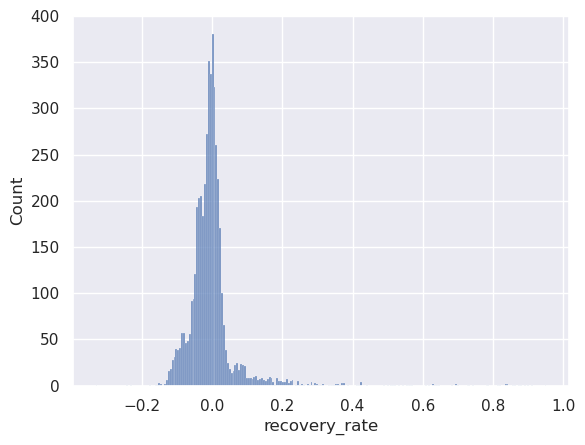

In [125]:
sns.histplot(lgd_targets_stage_2_test - y_hat_test_lgd_stage_2)


In [126]:
pickle.dump(reg_lgd_st_2, open('../data/lgd_model_stage_2.sav', 'wb'))

## LGD : Combine stage 1 + stage 2

In [127]:
y_hat_test_lgd_stage_2_all = reg_lgd_st_2.predict(lgd_inputs_stage_1_test)

In [128]:
y_hat_test_lgd_stage_2_all

array([0.10610923, 0.15761235, 0.09715261, ..., 0.14875221, 0.08835487,
       0.13009296])

In [129]:
y_hat_test_lgd = y_hat_test_lgd_stage_1 * y_hat_test_lgd_stage_2_all

In [130]:
pd.DataFrame(y_hat_test_lgd).describe()

,0
count,8495.000000
mean,0.078323
std,0.051882
min,-0.014771
25%,0.000000
50%,0.095527
75%,0.118824
max,0.205454


In [131]:
y_hat_test_lgd = np.where(y_hat_test_lgd < 0, 0, y_hat_test_lgd)
y_hat_test_lgd = np.where(y_hat_test_lgd > 1, 1, y_hat_test_lgd)

In [132]:
pd.DataFrame(y_hat_test_lgd).describe()

,0
count,8495.000000
mean,0.078326
std,0.051877
min,0.000000
25%,0.000000
50%,0.095527
75%,0.118824
max,0.205454


# EAD model

In [88]:
with pd.option_context('display.max_columns', None):
    display(inputs_test_with_ref_cat.head())

,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G,home_ownership:RENT_OTHER_NONE_ANY,home_ownership:OWN,home_ownership:MORTGAGE,addr_state:ND_NE_IA_NV_FL_HI_AL,addr_state:NM_VA,addr_state:NY,addr_state:OK_TN_MO_LA_MD_NC,addr_state:CA,addr_state:UT_KY_AZ_NJ,addr_state:AR_MI_PA_OH_MN,addr_state:RI_MA_DE_SD_IN,addr_state:GA_WA_OR,addr_state:WI_MT,addr_state:TX,addr_state:IL_CT,addr_state:KS_SC_CO_VT_AK_MS,addr_state:WV_NH_WY_DC_ME_ID,verification_status:Not Verified,verification_status:Source Verified,verification_status:Verified,purpose:educ__sm_b__wedd__ren_en__mov__house,purpose:credit_card,purpose:debt_consolidation,purpose:oth__med__vacation,purpose:major_purch__car__home_impr,initial_list_status:f,initial_list_status:w,term:36,term:60,emp_length:0,emp_length:1,emp_length:2-4,emp_length:5-6,emp_length:7-9,emp_length:10,mths_since_issue_d:<38,mths_since_issue_d:38-39,mths_since_issue_d:40-41,mths_since_issue_d:42-48,mths_since_issue_d:49-52,mths_since_issue_d:53-64,mths_since_issue_d:65-84,mths_since_issue_d:>84,int_rate:<9.548,int_rate:9.548-12.025,int_rate:12.025-15.74,int_rate:15.74-20.281,int_rate:>20.281,mths_since_earliest_cr_line:<140,mths_since_earliest_cr_line:141-164,mths_since_earliest_cr_line:165-247,mths_since_earliest_cr_line:248-270,mths_since_earliest_cr_line:271-352,mths_since_earliest_cr_line:>352,inq_last_6mths:0,inq_last_6mths:1-2,inq_last_6mths:3-6,inq_last_6mths:>6,acc_now_delinq:0,acc_now_delinq:>=1,annual_inc:<20K,annual_inc:20K-30K,annual_inc:30K-40K,annual_inc:40K-50K,annual_inc:50K-60K,annual_inc:60K-70K,annual_inc:70K-80K,annual_inc:80K-90K,annual_inc:90K-100K,annual_inc:100K-120K,annual_inc:120K-140K,annual_inc:>140K,dti:<=1.4,dti:1.4-3.5,dti:3.5-7.7,dti:7.7-10.5,dti:10.5-16.1,dti:16.1-20.3,dti:20.3-21.7,dti:21.7-22.4,dti:22.4-35,dti:>35,mths_since_last_delinq:Missing,mths_since_last_delinq:0-3,mths_since_last_delinq:4-30,mths_since_last_delinq:31-56,mths_since_last_delinq:>=57,mths_since_last_record:Missing,mths_since_last_record:0-2,mths_since_last_record:3-20,mths_since_last_record:21-31,mths_since_last_record:32-80,mths_since_last_record:81-86,mths_since_last_record:>=86
362514,False,False,True,False,False,False,False,False,False,True,0,0,False,0,True,0,0,0,0,0,False,0,0,0,False,False,True,0,False,False,0,1,True,False,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
288564,False,False,False,False,True,False,False,False,False,True,0,0,False,0,False,0,0,1,0,0,False,0,0,0,False,False,True,0,True,False,0,0,False,True,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0
213591,False,False,True,False,False,False,False,False,False,True,0,0,False,0,False,1,0,0,0,0,False,0,0,0,False,False,True,0,False,True,0,0,True,False,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
263083,False,False,True,False,False,False,False,False,False,True,0,0,False,0,False,0,1,0,0,0,False,0,0,0,False,True,False,0,False,True,0,0,False,True,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
165001,True,False,False,False,False,False,False,False,False,True,0,0,False,0,False,0,1,0,0,0,False,0,0,0,False,False,True,0,False,True,0,0,True,False,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0


In [89]:
summary_table.tail()

,Feature name,Coefficients,p_values
80,mths_since_last_record:3-20,0.208104,0.077745
81,mths_since_last_record:21-31,0.120604,0.261157
82,mths_since_last_record:32-80,0.276375,0.000435
83,mths_since_last_record:81-86,-0.091750,0.284216
84,mths_since_last_record:>=86,-0.004813,0.949403


In [90]:
y_hat_test_proba

array([0.92423583, 0.85019704, 0.88515548, ..., 0.97307279, 0.95977633,
       0.95206567])

## Creating a Scorecard

In [91]:
ref_categories

['grade:G',
 'home_ownership:RENT_OTHER_NONE_ANY',
 'addr_state:ND_NE_IA_NV_FL_HI_AL',
 'verification_status:Verified',
 'purpose:educ__sm_b__wedd__ren_en__mov__house',
 'initial_list_status:f',
 'term:60',
 'emp_length:0',
 'mths_since_issue_d:>84',
 'int_rate:>20.281',
 'mths_since_earliest_cr_line:<140',
 'inq_last_6mths:>6',
 'acc_now_delinq:0',
 'annual_inc:<20K',
 'dti:>35',
 'mths_since_last_delinq:0-3',
 'mths_since_last_record:0-2']

In [92]:
df_ref_categories = pd.DataFrame(ref_categories, columns=["Feature name"])
df_ref_categories["Coefficients"] = 0
df_ref_categories["p_values"] = np.NaN
df_ref_categories

,Feature name,Coefficients,p_values
0,grade:G,0,NaN
1,home_ownership:RENT_OTHER_NONE_ANY,0,NaN
2,addr_state:ND_NE_IA_NV_FL_HI_AL,0,NaN
3,verification_status:Verified,0,NaN
4,purpose:educ__sm_b__wedd__ren_en__mov__house,0,NaN
5,initial_list_status:f,0,NaN
6,term:60,0,NaN
7,emp_length:0,0,NaN
8,mths_since_issue_d:>84,0,NaN
9,int_rate:>20.281,0,NaN


In [93]:
df_scorecard = pd.concat([summary_table, df_ref_categories])
df_scorecard = df_scorecard.reset_index()
df_scorecard

,index,Feature name,Coefficients,p_values
0,0,Intercept,-0.445985,NaN
1,1,grade:A,0.944051,4.229369e-25
2,2,grade:B,0.732144,1.440979e-32
3,3,grade:C,0.549044,7.371959e-22
4,4,grade:D,0.373379,5.637468e-12
...,...,...,...,...
97,12,acc_now_delinq:0,0.000000,NaN
98,13,annual_inc:<20K,0.000000,NaN
99,14,dti:>35,0.000000,NaN
100,15,mths_since_last_delinq:0-3,0.000000,NaN


In [94]:
df_scorecard["Original feature name"] = df_scorecard["Feature name"].str.split(":").map(lambda x : x[0])
# This command also get the same result
# df_scorecard["Original feature name"] = df_scorecard["Feature name"].str.split(":").str.get(0)

In [95]:
df_scorecard

,index,Feature name,Coefficients,p_values,Original feature name
0,0,Intercept,-0.445985,NaN,Intercept
1,1,grade:A,0.944051,4.229369e-25,grade
2,2,grade:B,0.732144,1.440979e-32,grade
3,3,grade:C,0.549044,7.371959e-22,grade
4,4,grade:D,0.373379,5.637468e-12,grade
...,...,...,...,...,...
97,12,acc_now_delinq:0,0.000000,NaN,acc_now_delinq
98,13,annual_inc:<20K,0.000000,NaN,annual_inc
99,14,dti:>35,0.000000,NaN,dti
100,15,mths_since_last_delinq:0-3,0.000000,NaN,mths_since_last_delinq


In [96]:
# FICO score
# Min = worst borrower; coefficient yield lowest result
min_score = 300
# Man = best borrower; coefficient yield max result
max_score = 850

In [97]:
df_scorecard.groupby("Original feature name")["Coefficients"].min()

Original feature name
Intercept                     -0.445985
acc_now_delinq                 0.000000
addr_state                     0.000000
annual_inc                    -0.179924
dti                           -0.137457
emp_length                     0.000000
grade                          0.000000
home_ownership                 0.000000
initial_list_status            0.000000
inq_last_6mths                -0.080300
int_rate                       0.000000
mths_since_earliest_cr_line    0.000000
mths_since_issue_d            -0.007180
mths_since_last_delinq         0.000000
mths_since_last_record        -0.091750
purpose                        0.000000
term                           0.000000
verification_status           -0.013063
Name: Coefficients, dtype: float64

In [98]:
min_sum_coef = df_scorecard.groupby("Original feature name")["Coefficients"].min().sum()
min_sum_coef

-0.9556596161244878

In [99]:
df_scorecard.groupby("Original feature name")["Coefficients"].max()

Original feature name
Intercept                     -0.445985
acc_now_delinq                 0.147718
addr_state                     0.500647
annual_inc                     0.482019
dti                            0.203104
emp_length                     0.133383
grade                          0.944051
home_ownership                 0.105095
initial_list_status            0.049503
inq_last_6mths                 0.271788
int_rate                       0.964427
mths_since_earliest_cr_line    0.152760
mths_since_issue_d             1.133686
mths_since_last_delinq         0.150261
mths_since_last_record         0.276375
purpose                        0.283008
term                           0.080814
verification_status            0.080358
Name: Coefficients, dtype: float64

In [100]:
max_sum_coef = df_scorecard.groupby("Original feature name")["Coefficients"].max().sum()
max_sum_coef

5.513010997799627

In [101]:
df_scorecard["Score - Calculation"] = df_scorecard["Coefficients"]*(max_score - min_score)/(max_sum_coef - min_sum_coef)

In [102]:
df_scorecard

,index,Feature name,Coefficients,p_values,Original feature name,Score - Calculation
0,0,Intercept,-0.445985,NaN,Intercept,-37.919935
1,1,grade:A,0.944051,4.229369e-25,grade,80.268148
2,2,grade:B,0.732144,1.440979e-32,grade,62.250667
3,3,grade:C,0.549044,7.371959e-22,grade,46.682562
4,4,grade:D,0.373379,5.637468e-12,grade,31.746632
...,...,...,...,...,...,...
97,12,acc_now_delinq:0,0.000000,NaN,acc_now_delinq,0.000000
98,13,annual_inc:<20K,0.000000,NaN,annual_inc,0.000000
99,14,dti:>35,0.000000,NaN,dti,0.000000
100,15,mths_since_last_delinq:0-3,0.000000,NaN,mths_since_last_delinq,0.000000


In [103]:
df_scorecard.loc[0, "Score - Calculation"]= ((df_scorecard.loc[0, "Coefficients"] - min_sum_coef) / (max_sum_coef - min_sum_coef) ) * (max_score - min_score)+min_score

In [104]:
df_scorecard

,index,Feature name,Coefficients,p_values,Original feature name,Score - Calculation
0,0,Intercept,-0.445985,NaN,Intercept,343.335213
1,1,grade:A,0.944051,4.229369e-25,grade,80.268148
2,2,grade:B,0.732144,1.440979e-32,grade,62.250667
3,3,grade:C,0.549044,7.371959e-22,grade,46.682562
4,4,grade:D,0.373379,5.637468e-12,grade,31.746632
...,...,...,...,...,...,...
97,12,acc_now_delinq:0,0.000000,NaN,acc_now_delinq,0.000000
98,13,annual_inc:<20K,0.000000,NaN,annual_inc,0.000000
99,14,dti:>35,0.000000,NaN,dti,0.000000
100,15,mths_since_last_delinq:0-3,0.000000,NaN,mths_since_last_delinq,0.000000


In [105]:
df_scorecard["Score - Preliminary"] = df_scorecard["Score - Calculation"].round()

In [106]:
df_scorecard

,index,Feature name,Coefficients,p_values,Original feature name,Score - Calculation,Score - Preliminary
0,0,Intercept,-0.445985,NaN,Intercept,343.335213,343.0
1,1,grade:A,0.944051,4.229369e-25,grade,80.268148,80.0
2,2,grade:B,0.732144,1.440979e-32,grade,62.250667,62.0
3,3,grade:C,0.549044,7.371959e-22,grade,46.682562,47.0
4,4,grade:D,0.373379,5.637468e-12,grade,31.746632,32.0
...,...,...,...,...,...,...,...
97,12,acc_now_delinq:0,0.000000,NaN,acc_now_delinq,0.000000,0.0
98,13,annual_inc:<20K,0.000000,NaN,annual_inc,0.000000,0.0
99,14,dti:>35,0.000000,NaN,dti,0.000000,0.0
100,15,mths_since_last_delinq:0-3,0.000000,NaN,mths_since_last_delinq,0.000000,0.0


In [107]:
min_sum_score_prel = df_scorecard.groupby("Original feature name")["Score - Preliminary"].min().sum()
min_sum_score_prel

299.0

The min score less = 300, due to rounding effect. Then identify the min score and add +1 to make sum min = 300

In [108]:
max_sum_score_prel = df_scorecard.groupby("Original feature name")["Score - Preliminary"].max().sum()
max_sum_score_prel

849.0

The max score not = 850, due to rounding effect. Then identify the max score and add +1 to make sum max = 850

In [109]:
df_scorecard.groupby("Original feature name")["Score - Preliminary"].max()

Original feature name
Intercept                      343.0
acc_now_delinq                  13.0
addr_state                      43.0
annual_inc                      41.0
dti                             17.0
emp_length                      11.0
grade                           80.0
home_ownership                   9.0
initial_list_status              4.0
inq_last_6mths                  23.0
int_rate                        82.0
mths_since_earliest_cr_line     13.0
mths_since_issue_d              96.0
mths_since_last_delinq          13.0
mths_since_last_record          23.0
purpose                         24.0
term                             7.0
verification_status              7.0
Name: Score - Preliminary, dtype: float64

In [113]:
df_scorecard["Difference"] = df_scorecard["Score - Preliminary"] - df_scorecard["Score - Calculation"]

In [114]:
df_scorecard.sort_values(["Score - Preliminary", "Difference"], ascending=[False, True])

,index,Feature name,Coefficients,p_values,Original feature name,Score - Calculation,Score - Preliminary,Difference
0,0,Intercept,-0.445985,NaN,Intercept,343.335213,343.0,-0.335213
35,35,mths_since_issue_d:<38,1.133686,9.981814e-203,mths_since_issue_d,96.391871,96.0,-0.391871
42,42,int_rate:<9.548,0.964427,1.130093e-36,int_rate,82.000555,82.0,-0.000555
36,36,mths_since_issue_d:38-39,0.944140,1.063478e-176,mths_since_issue_d,80.275689,80.0,-0.275689
1,1,grade:A,0.944051,4.229369e-25,grade,80.268148,80.0,-0.268148
...,...,...,...,...,...,...,...,...
83,83,mths_since_last_record:81-86,-0.091750,2.842163e-01,mths_since_last_record,-7.801098,-8.0,-0.198902
73,73,dti:21.7-22.4,-0.093388,1.693526e-01,dti,-7.940296,-8.0,-0.059704
56,56,annual_inc:30K-40K,-0.115858,5.255335e-03,annual_inc,-9.850819,-10.0,-0.149181
74,74,dti:22.4-35,-0.137457,2.400711e-02,dti,-11.687297,-12.0,-0.312703


The `annual_inc:20K-30K	` was most impact of round down from -15.29 to -15.0  
Then +1 to make mininum score up = 300

The `mths_since_issue_d:<38` have highest score (87) and also was effected by rounding most (-0.38 diff).   
Then add +1 score to this features

In [115]:
df_scorecard["Score - Final"] = df_scorecard["Score - Preliminary"]

In [116]:
df_scorecard.loc[74, "Score - Final"] = df_scorecard.loc[74,"Score - Preliminary"] + 1

In [117]:
df_scorecard.loc[35,"Score - Final"] = df_scorecard.loc[35,"Score - Preliminary"] + 1

In [119]:
df_scorecard.groupby("Original feature name")["Score - Final"].min().sum()

300.0

In [120]:
df_scorecard.groupby("Original feature name")["Score - Final"].max().sum()

850.0

## Calculating Credit Score

In [121]:
inputs_test_with_ref_cat.head()

,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G,home_ownership:RENT_OTHER_NONE_ANY,home_ownership:OWN,home_ownership:MORTGAGE,...,mths_since_last_delinq:4-30,mths_since_last_delinq:31-56,mths_since_last_delinq:>=57,mths_since_last_record:Missing,mths_since_last_record:0-2,mths_since_last_record:3-20,mths_since_last_record:21-31,mths_since_last_record:32-80,mths_since_last_record:81-86,mths_since_last_record:>=86
362514,False,False,True,False,False,False,False,False,False,True,...,0,0,0,1,0,0,0,0,0,0
288564,False,False,False,False,True,False,False,False,False,True,...,0,0,0,1,0,0,0,0,0,0
213591,False,False,True,False,False,False,False,False,False,True,...,0,1,0,1,0,0,0,0,0,0
263083,False,False,True,False,False,False,False,False,False,True,...,0,0,0,1,0,0,0,0,0,0
165001,True,False,False,False,False,False,False,False,False,True,...,0,1,0,1,0,0,0,0,0,0


In [122]:
df_scorecard

,index,Feature name,Coefficients,p_values,Original feature name,Score - Calculation,Score - Preliminary,Difference,Score - Final
0,0,Intercept,-0.445985,NaN,Intercept,343.335213,343.0,-0.335213,343.0
1,1,grade:A,0.944051,4.229369e-25,grade,80.268148,80.0,-0.268148,80.0
2,2,grade:B,0.732144,1.440979e-32,grade,62.250667,62.0,-0.250667,62.0
3,3,grade:C,0.549044,7.371959e-22,grade,46.682562,47.0,0.317438,47.0
4,4,grade:D,0.373379,5.637468e-12,grade,31.746632,32.0,0.253368,32.0
...,...,...,...,...,...,...,...,...,...
97,12,acc_now_delinq:0,0.000000,NaN,acc_now_delinq,0.000000,0.0,0.000000,0.0
98,13,annual_inc:<20K,0.000000,NaN,annual_inc,0.000000,0.0,0.000000,0.0
99,14,dti:>35,0.000000,NaN,dti,0.000000,0.0,0.000000,0.0
100,15,mths_since_last_delinq:0-3,0.000000,NaN,mths_since_last_delinq,0.000000,0.0,0.000000,0.0


In [123]:
# inputs_test_with_ref_cat.reset_index().melt(id_vars="index", var_name="Feature name").set_index("Feature name")

In [124]:
# (inputs_test_with_ref_cat.reset_index().melt(id_vars="index", var_name="Feature name").set_index("Feature name")
#   .merge(df_scorecard.set_index("Feature name", drop=True), left_index=True, right_index=True, how="inner")
# )

In [125]:
obs_feature_score = \
(inputs_test_with_ref_cat.reset_index().melt(id_vars="index", var_name="Feature name")
 .merge(df_scorecard.drop("index", axis="columns"), on="Feature name", how="inner")
 .assign(feature_score = lambda x : x["value"]*x["Score - Final"])
)

In [126]:
df_scorecard.loc[df_scorecard["Feature name"]=="Intercept", "Score - Final"].values[0]

343.0

In [127]:
obs_score = obs_feature_score.groupby("index").agg(score_no_intercept = ("feature_score", "sum"))
obs_score["score"] = obs_score["score_no_intercept"] + df_scorecard.loc[df_scorecard["Feature name"]=="Intercept", "Score - Final"].values[0]

In [128]:
obs_score

,score_no_intercept,score
index,,
6,114.0,457.0
24,226.0,569.0
26,159.0,502.0
30,250.0,593.0
31,282.0,625.0
...,...,...
466274,286.0,629.0
466280,250.0,593.0
466281,158.0,501.0


In [129]:
inputs_test_with_ref_cat

,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G,home_ownership:RENT_OTHER_NONE_ANY,home_ownership:OWN,home_ownership:MORTGAGE,...,mths_since_last_delinq:4-30,mths_since_last_delinq:31-56,mths_since_last_delinq:>=57,mths_since_last_record:Missing,mths_since_last_record:0-2,mths_since_last_record:3-20,mths_since_last_record:21-31,mths_since_last_record:32-80,mths_since_last_record:81-86,mths_since_last_record:>=86
362514,False,False,True,False,False,False,False,False,False,True,...,0,0,0,1,0,0,0,0,0,0
288564,False,False,False,False,True,False,False,False,False,True,...,0,0,0,1,0,0,0,0,0,0
213591,False,False,True,False,False,False,False,False,False,True,...,0,1,0,1,0,0,0,0,0,0
263083,False,False,True,False,False,False,False,False,False,True,...,0,0,0,1,0,0,0,0,0,0
165001,True,False,False,False,False,False,False,False,False,True,...,0,1,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,False,True,False,False,False,False,False,False,False,True,...,0,0,0,1,0,0,0,0,0,0
296284,False,True,False,False,False,False,False,True,False,False,...,0,0,1,1,0,0,0,0,0,0
61777,True,False,False,False,False,False,False,False,False,True,...,0,0,0,1,0,0,0,0,0,0
91763,True,False,False,False,False,False,False,False,False,True,...,0,0,0,1,0,0,0,0,0,0


In [130]:
inputs_test_with_ref_cat_w_intercept = inputs_test_with_ref_cat

In [131]:
inputs_test_with_ref_cat_w_intercept.insert(0, "Intercept", 1)

In [132]:
inputs_test_with_ref_cat_w_intercept

,Intercept,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G,home_ownership:RENT_OTHER_NONE_ANY,home_ownership:OWN,...,mths_since_last_delinq:4-30,mths_since_last_delinq:31-56,mths_since_last_delinq:>=57,mths_since_last_record:Missing,mths_since_last_record:0-2,mths_since_last_record:3-20,mths_since_last_record:21-31,mths_since_last_record:32-80,mths_since_last_record:81-86,mths_since_last_record:>=86
362514,1,False,False,True,False,False,False,False,False,False,...,0,0,0,1,0,0,0,0,0,0
288564,1,False,False,False,False,True,False,False,False,False,...,0,0,0,1,0,0,0,0,0,0
213591,1,False,False,True,False,False,False,False,False,False,...,0,1,0,1,0,0,0,0,0,0
263083,1,False,False,True,False,False,False,False,False,False,...,0,0,0,1,0,0,0,0,0,0
165001,1,True,False,False,False,False,False,False,False,False,...,0,1,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,1,False,True,False,False,False,False,False,False,False,...,0,0,0,1,0,0,0,0,0,0
296284,1,False,True,False,False,False,False,False,True,False,...,0,0,1,1,0,0,0,0,0,0
61777,1,True,False,False,False,False,False,False,False,False,...,0,0,0,1,0,0,0,0,0,0
91763,1,True,False,False,False,False,False,False,False,False,...,0,0,0,1,0,0,0,0,0,0


In [133]:
inputs_test_with_ref_cat_w_intercept = inputs_test_with_ref_cat_w_intercept[df_scorecard["Feature name"].values]

In [134]:
inputs_test_with_ref_cat_w_intercept.head()

,Intercept,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,home_ownership:OWN,home_ownership:MORTGAGE,addr_state:NM_VA,...,emp_length:0,mths_since_issue_d:>84,int_rate:>20.281,mths_since_earliest_cr_line:<140,inq_last_6mths:>6,acc_now_delinq:0,annual_inc:<20K,dti:>35,mths_since_last_delinq:0-3,mths_since_last_record:0-2
362514,1,False,False,True,False,False,False,False,True,0,...,1,0,0,0,0,1,0,0,0,0
288564,1,False,False,False,False,True,False,False,True,0,...,0,0,1,0,0,1,0,0,1,0
213591,1,False,False,True,False,False,False,False,True,0,...,0,0,0,0,0,1,0,0,0,0
263083,1,False,False,True,False,False,False,False,True,0,...,0,0,0,1,0,1,0,0,0,0
165001,1,True,False,False,False,False,False,False,True,0,...,0,0,0,0,0,1,0,0,0,0


In [135]:
scorecard_score = df_scorecard["Score - Final"]

In [136]:
inputs_test_with_ref_cat_w_intercept.shape

(93257, 102)

In [137]:
scorecard_score.shape

(102,)

In [138]:
scorecard_score = scorecard_score.values.reshape(102, 1)

In [139]:
scorecard_score.shape

(102, 1)

In [140]:
y_score = inputs_test_with_ref_cat_w_intercept.dot(scorecard_score)

In [141]:
y_score

,0
362514,595.0
288564,530.0
213591,556.0
263083,613.0
165001,673.0
...,...
115,551.0
296284,665.0
61777,687.0
91763,652.0


## From score to PD

In [211]:
sum_coef_from_score = ((y_score - min_score) / (max_score - min_score)) * (max_sum_coef - min_sum_coef) + min_sum_coef

In [223]:
sum_coef_from_score.map(np.exp)

,0
362514,12.353014
288564,5.684025
213591,7.808497
263083,15.265601
165001,30.916041
...,...
115,7.362551
296284,28.139814
61777,36.449664
91763,24.150126


In [224]:
y_hat_proba_from_score = sum_coef_from_score.map(np.exp) / (sum_coef_from_score.map(np.exp) + 1)

In [225]:
y_hat_proba_from_score.head()

,0
362514,0.925111
288564,0.850390
213591,0.886473
263083,0.938521
165001,0.968668


## Setting cut-offs

In [226]:
tr = 0.9
df_actual_predicted_proba["y_hat_test"] = np.where(df_actual_predicted_proba["y_hat_test_proba"] > tr, 1, 0)

In [227]:
df_actual_predicted_proba

,loan_data_targets_test,y_hat_test_proba,y_hat_test
362514,1,0.924236,1
288564,1,0.850197,0
213591,1,0.885155,0
263083,1,0.938722,1
165001,1,0.968578,1
...,...,...,...
115,1,0.880294,0
296284,1,0.966106,1
61777,0,0.973073,1
91763,1,0.959776,1


In [228]:
pd.crosstab(df_actual_predicted_proba["loan_data_targets_test"], df_actual_predicted_proba["y_hat_test"], 
            rownames=["Actual"], colnames=["Predicted"])

Predicted,0,1
Actual,,
0,7383,2807
1,35819,47248


In [229]:
from sklearn.metrics import roc_curve, roc_auc_score

In [230]:
roc_curve(df_actual_predicted_proba["loan_data_targets_test"], df_actual_predicted_proba["y_hat_test_proba"])

(array([0.        , 0.        , 0.        , ..., 0.99990186, 0.99990186,
        1.        ]),
 array([0.00000000e+00, 1.20384750e-05, 4.81538999e-05, ...,
        9.99975923e-01, 1.00000000e+00, 1.00000000e+00]),
 array([       inf, 0.99256562, 0.99101667, ..., 0.50594177, 0.49513903,
        0.49481669]))

In [231]:
fpr, tpr, thresholds = roc_curve(df_actual_predicted_proba["loan_data_targets_test"], df_actual_predicted_proba["y_hat_test_proba"])

In [232]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_theme()

Text(0.5, 1.0, 'ROC Curve')

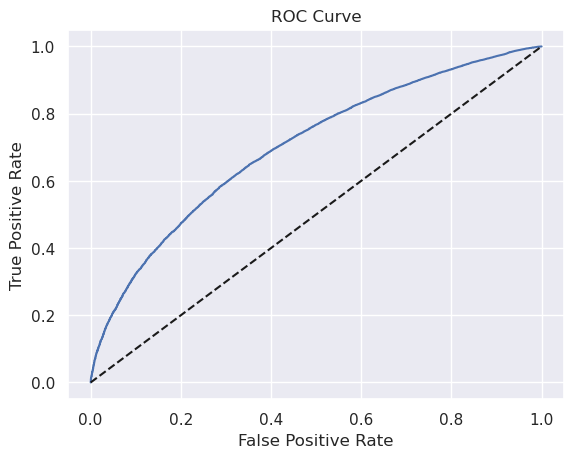

In [233]:
plt.plot(fpr, tpr)
plt.plot(fpr, fpr, linestyle="--", color="k")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")

In [234]:
AUROC = roc_auc_score(df_actual_predicted_proba["loan_data_targets_test"], df_actual_predicted_proba["y_hat_test_proba"])
AUROC

0.7017789162307977

In [236]:
thresholds

array([       inf, 0.99256562, 0.99101667, ..., 0.50594177, 0.49513903,
       0.49481669])

In [237]:
thresholds.shape

(17444,)

In [238]:
df_cutoffs = pd.concat([pd.DataFrame(thresholds), pd.DataFrame(fpr), pd.DataFrame(tpr)], axis=1)

In [240]:
df_cutoffs.columns = ["thresholds", "fpr", "tpr"]

In [241]:
df_cutoffs

,thresholds,fpr,tpr
0,inf,0.000000,0.000000
1,0.992566,0.000000,0.000012
2,0.991017,0.000000,0.000048
3,0.990635,0.000098,0.000048
4,0.989188,0.000098,0.000554
...,...,...,...
17439,0.527945,0.999509,0.999940
17440,0.525426,0.999509,0.999976
17441,0.505942,0.999902,0.999976
17442,0.495139,0.999902,1.000000


In [ ]:
1 - 1/np.power(10, 16)

0.9999999999999999

In [244]:
df_cutoffs["Score"] = (np.log(df_cutoffs["thresholds"] / (1 - df_cutoffs["thresholds"])) - min_sum_coef) * ((max_score - min_score) / (max_sum_coef - min_sum_coef)) + min_score

In [245]:
df_cutoffs

,thresholds,fpr,tpr,Score
0,inf,0.000000,0.000000,NaN
1,0.992566,0.000000,0.000012,797.383551
2,0.991017,0.000000,0.000048,781.159363
3,0.990635,0.000098,0.000048,777.584208
4,0.989188,0.000098,0.000554,765.249532
...,...,...,...,...
17439,0.527945,0.999509,0.999940,390.769255
17440,0.525426,0.999509,0.999976,389.910009
17441,0.505942,0.999902,0.999976,383.276044
17442,0.495139,0.999902,1.000000,379.601876


In [246]:
df_cutoffs["Score"][0] = max_score

/tmp/ipykernel_5801/604231348.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_cutoffs["Score"][0] = max_score


In [247]:
df_cutoffs

,thresholds,fpr,tpr,Score
0,inf,0.000000,0.000000,850.000000
1,0.992566,0.000000,0.000012,797.383551
2,0.991017,0.000000,0.000048,781.159363
3,0.990635,0.000098,0.000048,777.584208
4,0.989188,0.000098,0.000554,765.249532
...,...,...,...,...
17439,0.527945,0.999509,0.999940,390.769255
17440,0.525426,0.999509,0.999976,389.910009
17441,0.505942,0.999902,0.999976,383.276044
17442,0.495139,0.999902,1.000000,379.601876


In [248]:
def n_approved(p):
    return np.where(df_actual_predicted_proba["y_hat_test_proba"] >= p, 1, 0).sum()

In [251]:
df_cutoffs["N_Approved"] = df_cutoffs["thresholds"].apply(n_approved)
df_cutoffs["N_Rejected"] = df_actual_predicted_proba["y_hat_test_proba"].shape[0] - df_cutoffs["N_Approved"]
df_cutoffs["Approval Rate"] = df_cutoffs["N_Approved"] / df_actual_predicted_proba["y_hat_test_proba"].shape[0]
df_cutoffs["Rejection Rate"] = 1-df_cutoffs["Approval Rate"]

In [253]:
df_cutoffs.head()

,thresholds,fpr,tpr,Score,N_Approved,N_Rejected,Approval Rate,Rejection Rate
0,inf,0.000000,0.000000,850.000000,0,93257,0.000000,1.000000
1,0.992566,0.000000,0.000012,797.383551,1,93256,0.000011,0.999989
2,0.991017,0.000000,0.000048,781.159363,4,93253,0.000043,0.999957
3,0.990635,0.000098,0.000048,777.584208,5,93252,0.000054,0.999946
4,0.989188,0.000098,0.000554,765.249532,47,93210,0.000504,0.999496


Cut-off, select from `Approval Rate` if target `Approval Rate` = 20% then

In [255]:
df_cutoffs[df_cutoffs["Approval Rate"] > 0.2]

,thresholds,fpr,tpr,Score,N_Approved,N_Rejected,Approval Rate,Rejection Rate
1127,0.951343,0.054858,0.217848,634.040994,18655,74602,0.200039,0.799961
1128,0.951342,0.054956,0.217848,634.039441,18656,74601,0.200049,0.799951
1129,0.951341,0.054956,0.217860,634.037669,18657,74600,0.200060,0.799940
1130,0.951338,0.055054,0.217860,634.032467,18658,74599,0.200071,0.799929
1131,0.951330,0.055054,0.217933,634.018727,18664,74593,0.200135,0.799865
...,...,...,...,...,...,...,...,...
17439,0.527945,0.999509,0.999940,390.769255,93247,10,0.999893,0.000107
17440,0.525426,0.999509,0.999976,389.910009,93250,7,0.999925,0.000075
17441,0.505942,0.999902,0.999976,383.276044,93254,3,0.999968,0.000032
17442,0.495139,0.999902,1.000000,379.601876,93256,1,0.999989,0.000011


If target `Approval Rate` 50%

In [256]:
df_cutoffs[df_cutoffs["Approval Rate"] >= 0.5]

,thresholds,fpr,tpr,Score,N_Approved,N_Rejected,Approval Rate,Rejection Rate
4749,0.906244,0.244848,0.531306,574.144573,46629,46628,0.500005,0.499995
4750,0.906205,0.244848,0.531619,574.105797,46655,46602,0.500284,0.499716
4751,0.906201,0.244946,0.531619,574.101852,46656,46601,0.500295,0.499705
4752,0.906182,0.244946,0.531800,574.082571,46671,46586,0.500456,0.499544
4753,0.906180,0.245044,0.531800,574.079910,46672,46585,0.500466,0.499534
...,...,...,...,...,...,...,...,...
17439,0.527945,0.999509,0.999940,390.769255,93247,10,0.999893,0.000107
17440,0.525426,0.999509,0.999976,389.910009,93250,7,0.999925,0.000075
17441,0.505942,0.999902,0.999976,383.276044,93254,3,0.999968,0.000032
17442,0.495139,0.999902,1.000000,379.601876,93256,1,0.999989,0.000011


In [10]:
inputs_train_with_ref_cat.to_csv('../data/inputs_train_with_ref_cat.csv')

In [142]:
df_scorecard.to_csv('../data/df_scorecard.csv')